In [0]:
%matplotlib inline

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=400,
                                         shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

torch.Size([3, 392, 242])


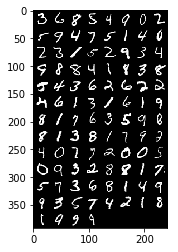

    3     6     8     5     4     9     0     2     5     9     4     7     5     1     4     0     2     3     1     5     2     9     3     4     9     8     8     4     1     8     3     8     5     4     3     6     2     6     2     2     4     6     1     3     1     6     1     9     8     1     7     6     3     5     9     8     8     1     3     8     1     7     9     2     4     0     7     7     2     0     0     5     0     9     3     2     8     8     1     7     5     7     3     6     8     1     4     9     9     3     5     7     4     2     1     8     1     9     9     9


In [0]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    print(img.shape)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap="gray")
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(100)))

In [0]:
import torch.nn as nn
import torch.nn.functional as F


class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5*5, 120)
        self.fc2 = nn.Linear(120, 100)
        self.fc3 = nn.Linear(100, 10)
        self.smax = nn.Softmax()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.smax(x)
        return x


model = LeNet()

In [0]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.003)

In [0]:
for epoch in range(5):
  running_loss = 0.0
  i=0;
  for x,y in trainloader:
    output=model(x)
    loss=criterion(output,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    if i % 200 == 199:    # print every 200 mini-batches
      print('[%d, %5d] loss: %.3f' %
      (epoch + 1, i + 1, running_loss / 199))
      running_loss = 0.0
            
    i=i+1
print('Finished Training')



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[1,   200] loss: 1.762
[1,   400] loss: 1.587
[1,   600] loss: 1.516
[2,   200] loss: 1.511
[2,   400] loss: 1.506
[2,   600] loss: 1.501
[3,   200] loss: 1.498
[3,   400] loss: 1.499
[3,   600] loss: 1.498
[4,   200] loss: 1.496
[4,   400] loss: 1.496
[4,   600] loss: 1.497
[5,   200] loss: 1.495
[5,   400] loss: 1.494
[5,   600] loss: 1.494
Finished Training


**Testing...**



torch.Size([3, 1502, 242])


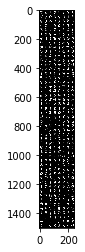

GroundTruth:      7     2     1     0     4     1     4     9     5     9     0     6     9     0     1     5     9     7     3     4     9     6     6     5     4     0     7     4     0     1     3     1     3     4     7     2     7     1     2     1     1     7     4     2     3     5     1     2     4     4     6     3     5     5     6     0     4     1     9     5     7     8     9     3     7     4     6     4     3     0     7     0     2     9     1     7     3     2     9     7     7     6     2     7     8     4     7     3     6     1     3     6     9     3     1     4     1     7     6     9     6     0     5     4     9     9     2     1     9     4     8     7     3     9     7     4     4     4     9     2     5     4     7     6     7     9     0     5     8     5     6     6     5     7     8     1     0     1     6     4     6     7     3     1     7     1     8     2     0     2     9     9     5     5     1     5     6     0     3     4     4     6     5     4   

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(400)))

In [0]:
outputs = model(images)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(400)))

Predicted:      7     2     1     0     4     1     4     9     5     9     0     6     9     0     1     5     9     7     8     4     9     6     6     5     4     0     7     4     0     1     3     1     3     4     7     2     7     1     2     1     1     7     4     2     3     5     1     2     4     4     6     3     5     5     6     0     4     1     9     5     7     8     9     3     7     4     6     4     3     0     7     0     2     9     1     7     3     2     9     7     7     6     2     7     8     4     7     3     6     1     3     6     9     3     1     4     1     7     6     9     6     0     5     4     9     9     2     1     9     4     8     7     3     9     7     4     4     4     9     2     5     4     7     6     4     9     0     5     8     5     6     6     5     7     8     1     0     1     6     4     6     7     3     1     7     1     8     2     0     4     9     8     5     5     1     5     6     0     3     4     4     6     5     4     

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the network on the 10000 test images: 97 %


In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(400):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of     0 : 99 %
Accuracy of     1 : 99 %
Accuracy of     2 : 95 %
Accuracy of     3 : 97 %
Accuracy of     4 : 99 %
Accuracy of     5 : 95 %
Accuracy of     6 : 97 %
Accuracy of     7 : 96 %
Accuracy of     8 : 98 %
Accuracy of     9 : 95 %
